In [14]:
from randoms import BasicRandGenerator, JKissRandEngine, JLKiss64RandEngine, ULM, ULLM
from matplotlib import pyplot as plt
import numpy as np

In [15]:
eng = JLKiss64RandEngine()

In [16]:
print(len(str(eng.Next())))
print(eng.MaxValue())

20
18446744073709551615


In [17]:
randoms = [eng.Next() / eng.MaxValue() for _ in range(1000)]

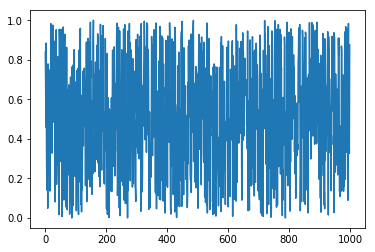

In [18]:
plt.plot(randoms)

(array([ 92., 104.,  87.,  76., 130.,  99.,  99.,  99., 105., 109.]),
 array([6.20712044e-04, 1.00542493e-01, 2.00464273e-01, 3.00386054e-01,
        4.00307835e-01, 5.00229615e-01, 6.00151396e-01, 7.00073176e-01,
        7.99994957e-01, 8.99916738e-01, 9.99838518e-01]),
 <a list of 10 Patch objects>)

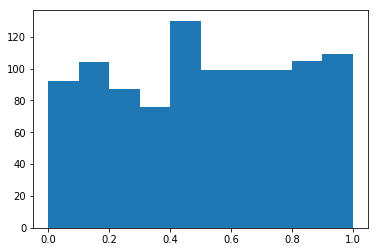

In [19]:
plt.hist(randoms)

In [20]:
from datetime import datetime

eng.Reseed(datetime.now().microsecond % ULM)
randoms = [eng.Next() / eng.MaxValue() for _ in range(1000000)]
np.median(randoms)

0.5003110841773957

In [21]:
np.median(medians)

0.4998557611833922